# Seasonal Volume Forecasting: Seasonal ARIMA, Holt-Winter, & Complex Exponential Smoothing

***
## About the data
This dataset is from an unnamed contact center company who wishes to forecast their incoming volume to assist in their workforce planning, and to maximize their productivity. It contains the daily received volume from October 2020 to March 2021, excluding the holidays and weekends. Saturday, Sunday and holiday data is set to 0.

First and foremost, we have to import the necessary packages we will use in this notebook, load the dataset and have a basic visualization to see the overview of what we are working on.

In [1]:
# Import the necessary packages

import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, HoltWinters, AutoCES
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

plt.rcParams['figure.figsize'] = (15, 5)

C:\Users\mhico\anaconda3\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Load dataset using Pandas library

df = pd.read_csv('volume_dataset.csv', parse_dates=['date'])

df.head()

,date,calls_received
0,2020-10-02,0
1,2020-10-03,2698
2,2020-10-04,3105
3,2020-10-05,2996
4,2020-10-06,3033


Text(0, 0.5, 'Volume Received')

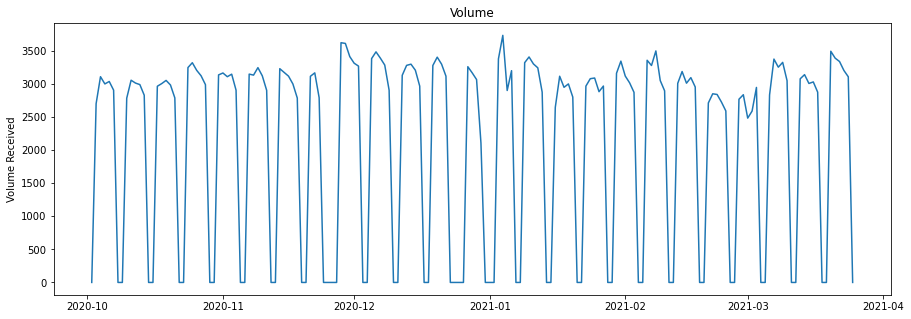

In [3]:
# Visualize data using matplotlib

plt.plot(df['date'], df['calls_received'])
plt.title('Volume')
plt.ylabel('Volume Received')

### Stationarity

For the Seasonal ARIMA model, we want to check whether the dataset is stationary. This means that across time, a dataset's variance and mean would not vary. A dataset that are usually non-stationary are those that have strong trend and seasonality. Looking at the graph above, we can see that trend is almost non-existent (no apparent direction). However, seasonality is obviously strong as this is a working day (weekday) data.

First, we have to statistically prove whether our data has a non-stationary trend. We will use the **Augmented Dickey-Fuller test (ADF Test)** for this. As a unit root test, this basically checks whether a time series dataset is defined by a trend. This means that the **null hypothesis (H0)**, if accepted, indicates a non-stationary dataset. The opposite applies if the **alternative hypothesis (H1)** is accepted: a stationary time series.

For this, we will use **95% confidence interval (p-value < 0.05)** to determine whether to accept or reject the null hypothesis.

In [4]:
# Import the adfuller() from statsmodels

from statsmodels.tsa.stattools import adfuller

# Instantiate the result in a variable, and print the results

result = adfuller(df.set_index(['date']))

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.6323715251484336
p-value: 0.0051714722498628265
Critical Values:
	1%: -3.471
	5%: -2.880
	10%: -2.576


Based on the result of ADF test, we can see that the **p-value is less than 0.05** and we can reject the null hypothesis. Therefore, our **dataset is stationary**.
***

For building our models, we will use the **StatsForecast** library.

According to the documentation, StatsForecast's dataframe always comprises of three distinct columns: **[unique_id]**, **[ds]**, and **[y]**.

1. The **[unique_id]** (string, int or category) represents an identifier for the series. *

2. The **[ds]** (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. *

3. The **[y]** (numeric) represents the measurement we wish to forecast. *

*<font size="1">*Note: Directly copied from the documentation website. References will be provide at the end.</font>*

In [5]:
# Create a 'unique_id' column

df['unique_id'] = 0

# Change columns 'date' and 'calls_received'(variable) to 'ds' and 'y' respectively

df = df.rename(columns = {
    'date': 'ds',
    'calls_received': 'y'
})

# Set the 'unique_id' column as index

df = df.set_index('unique_id')

df.head()

,ds,y
unique_id,,
0,2020-10-02,0
0,2020-10-03,2698
0,2020-10-04,3105
0,2020-10-05,2996
0,2020-10-06,3033


***
Since this is a Time-Series data, we will cross validate our output model by partitioning our dataset using the **Train-Test Split** method. This means that we will split the first (at least in our case) 80% as of our data as our **Train dataset**, and the remaining 20% for the **Test dataset**. This is done so we can properly guage the accuracy of our forecasting models.

We will input the **Train dataset** in our forecasting models, and use the **Test dataset** to check the viability thereof.

In [6]:
# Split the dataset to Train and Test

train = df.iloc[:int(len(df) * 0.8)].copy()
test = df.iloc[int(len(df) * 0.8):].copy()

***
With that, we create a list of our models, with their corresponding parameters, and instantiate the StatsForecast to train our data with the given models.

<font size="2">*All models' **season_length** parameter is set to 7 to explicitly state the dataset's seasonal pattern.*</font>

* __AutoARIMA__ - Since the algorithm will find the best parameters of the model based on our dataset, we made sure to set the starting point at 0. The only hyperparameter applied is D=1. This argument represents the number of seasonal difference. Since our data is strongly seasonal, we put **1** as its value.
* __HoltWinters__ - Given that our data contains zeroes, we defaulted to the **additive seasonality model**.
* __AutoCES__ - The default value of 'model' is 'Z', in which it will figure out the best parameter to be used based on our dataset. However, we have set it to 'S', which means *simple seasonality*.

In [7]:
# Create a list of forecasting models to be used with their corresponding parameters

models = [
    AutoARIMA(season_length = 7, D = 1, start_p = 0, start_q = 0, start_P = 0, start_Q = 0, alias = 'SARIMA'),
    HoltWinters(season_length = 7, error_type = 'A'),
    AutoCES(season_length = 7, model = 'S', alias = 'Complex ES')
]

In [8]:
# Make an instance of StatsForecast class as 'sf'

sf = StatsForecast(
    df = train,
    models = models,
    freq = 'd',
    n_jobs = -1
)

In [9]:
# Store the generated forecast to a variable

forecast_sf = sf.forecast(h = len(test))

forecast_sf.head()

,ds,SARIMA,HoltWinters,Complex ES
unique_id,,,,
0,2021-02-19,126.332230,-1.711039,0.000000
0,2021-02-20,3092.959961,2817.025391,2777.885010
0,2021-02-21,3273.149902,3225.187256,3212.182861
0,2021-02-22,3164.072266,3212.153320,3140.601318
0,2021-02-23,3060.063477,2890.378418,2961.923340


***
Let us import the necessary error metrics to measure the accuracy of our results. For this, we will use the three:

* Root Mean Squared Error
* Mean Absolute Scaled Error
* Root Mean Squared Scaled Error

In [10]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

We'll create a function for every accuracy metrics we will use.

In [11]:
# Put inside a variable and store in each model's name in a list

sarima, holt_winters, cse, test_data = (
    forecast_sf.reset_index()['SARIMA'],
    forecast_sf.reset_index()['HoltWinters'],
    forecast_sf.reset_index()['Complex ES'],
    test.reset_index()['y']
)

# Create accuracy metric functions to guage precision of models

def rmse(pred):
    mse = mean_squared_error(test_data, pred)
    return {
        'model': pred.name,
        'values': math.sqrt(mse),
        'metric': 'RMSE'
    }


def mase(pred):
    mae_y = mean_absolute_error(test_data, pred)
    mae_naive = mean_absolute_error(test_data, test_data.shift(1).replace(np.nan, 0))
    return {
        'model': pred.name,
        'values': mae_y / mae_naive,
        'metric': 'MASE'
    }


def smape(pred):
    return {
        'model': pred.name,
        'values': 1 / len(test_data) * np.sum(2 * np.abs(pred - test_data) / (np.abs(test_data) + np.abs(pred)) * 100),
        'metric': 'SMAPE'
    }

# List of model names for iteration

forecast_models = [
    sarima,
    holt_winters,
    cse
]

In [12]:
# Create an empty list to store each model's result

accuracy = []

# Create a 'for' loop to run every model and store it in the empty list created earlier.

for model in forecast_models:
    accuracy.append(rmse(model))
    accuracy.append(mase(model))
    accuracy.append(smape(model))
    
accur_df = pd.DataFrame(accuracy)

accur_df.pivot(index = 'model', columns = 'metric')

values                       
metric           MASE        RMSE      SMAPE
model                                       
Complex ES   0.193766  258.494665   6.057501
HoltWinters  0.207744  278.561543  63.610269
SARIMA       0.199546  252.266361  62.953537

Before we interpret the results of the accuracy metrics above, let us plot our data first.

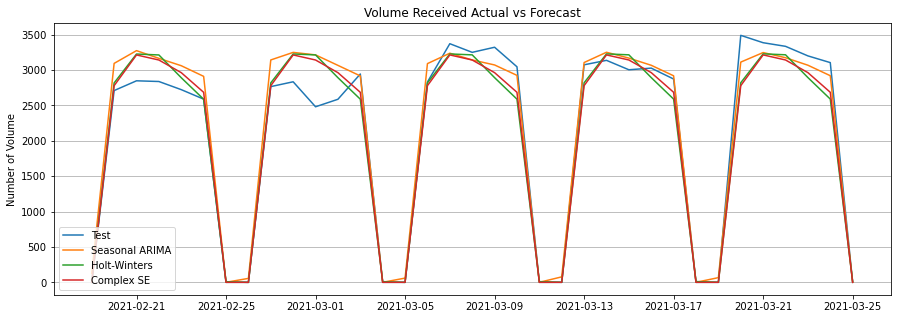

In [13]:
# Let us reset and set the index from 'unique_id' to 'ds' so we can properly plot our data

forecast_plot = forecast_sf.reset_index().set_index(['ds'])
test_plot = test.reset_index().set_index(['ds'])

# Initialize the plotting

plt.plot(test_plot['y'], label = 'Test')
plt.plot(forecast_plot['SARIMA'], label = 'Seasonal ARIMA')
plt.plot(forecast_plot['HoltWinters'], label = 'Holt-Winters')
plt.plot(forecast_plot['Complex ES'], label = 'Complex SE')

plt.title('Volume Received Actual vs Forecast')
plt.grid(which = 'major', axis = 'y')
plt.ylabel('Number of Volume')
plt.legend(loc = 'lower left')

### Interpretation
Based on the accuracy metrics' result, **Complex Exponential Smoothing** has the lowest results in both **Mean Absolute Scaled Error (MASE)**, and **Symmetric Mean Absolute Percentage Error (SMAPE)** with values of 0.193766 and 6.057501% respectively.

* __Mean Absolute Scaled Error (MASE)__
<br>To properly assess our model using this scale, we are targeting a value of MASE = < 1. Otherwise, our model is as good as its equivalent *t-1* (naive forecast) model. Therefore, given that the result shows a value MASE = 0.193766, we can say that our Complex ES did well compared it's naive equivalent.<br>
<br>
* __Symmetric Mean Absolute Percentage Error (SMAPE)__
<br> For SMAPE, a value of SMAPE >= 100% means your model presents a relatively high difference between your forecast and your actual data. In our Complex ES model, the result of SMAPE = 6.057501% shows that the model is good enough as it is, and comparing it other models, this is significantly better.